In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np
import om4labs

In [7]:
expname = "odiv-251"
path = f'/work/Katherine.Turner/CM4_storms/code/response'

archive_251 = "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp"
ds_ice = xr.open_mfdataset(f"{archive_251}/ice_1x1deg/ts/monthly/5yr/ice_1x1deg.*.EXT.nc", use_cftime=True)

ds_grid = xr.open_dataset(f"{archive_251}/ocean_monthly_1x1deg/ocean_monthly_1x1deg.static.nc")

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [21]:
ocean_area = ds_grid.areacello * ds_grid.wet

SO_area = ocean_area.sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})

In [25]:
varnames = ["hfds", "dic_stf_gas", "omldamax"]
lim0 = [0, -1.6e-7, 0, -250, -1.6e-7, 0]
lim1 = [250, 1.6e-7, 250, 0, 1.6e-7, 250]
cmaps = [plt.get_cmap("Blues", 10), plt.get_cmap("RdBu", 10), plt.get_cmap("inferno_r", 10),
         plt.get_cmap("Reds_r", 10), plt.get_cmap("RdBu", 10), plt.get_cmap("inferno_r", 10)]

# labels for figure
units = ["W", "mol C s$^{-1}$", "m"]
varnames_long = ["heat fluxes \n (W m$^{-2}$)", "CO$_2$ fluxes \n (mol C m$^{-2}$ s$^{-1}$)", "daily max MLD \n (m)"]
seas = ["Summer", "Winter"]
#xt = [SO_area_total.time.data[0], SO_area_total.time.data[90], SO_area_total.time.data[181], SO_area_total.time.data[273]]
#xt_labels = ["Jan-1", "Apr-1", "Jul-1", "Oct-1"]

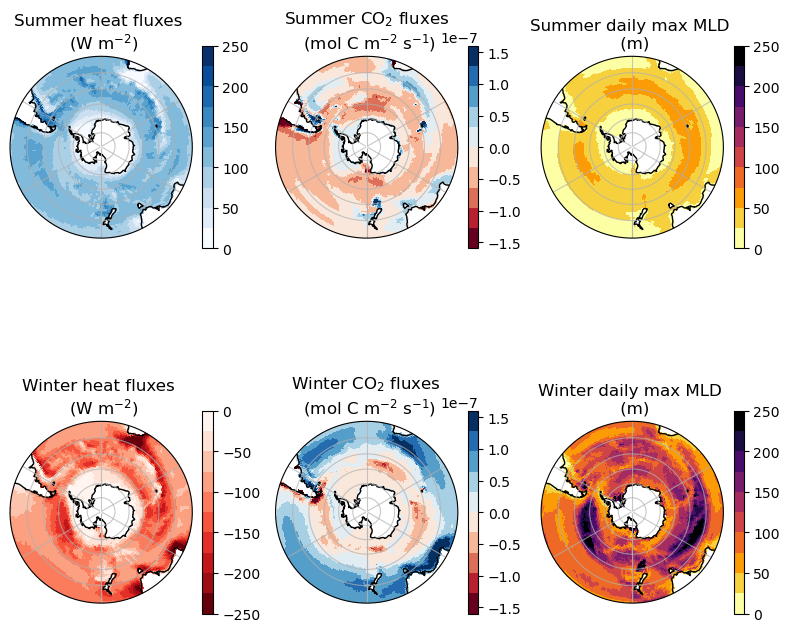

In [15]:
fig, axs = plt.subplots(figsize=(8, 8), nrows = 2, ncols = 3,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.flatten()

for i_v, v in enumerate(varnames):
    
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
#    SO_area_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()

#    SO_area_total.plot(ax=axs[i_v])
    
    for i in np.arange(2):
    
        ibox = (i)*3+i_v
    
        f = seasonal_means[i,:,:].plot(ax=axs[ibox], transform=ccrs.PlateCarree(), add_colorbar=False,
                                       vmin=lim0[ibox], 
                                       vmax=lim1[ibox],
                                       cmap=cmaps[ibox])
        axs[ibox].set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
        axs[ibox].gridlines(alpha=0.7)
        axs[ibox].set_boundary(circle, transform=axs[ibox].transAxes)
        axs[ibox].coastlines()
        axs[ibox].set_title(f"{seas[i]} {varnames_long[i_v]}")
        plt.colorbar(f, ax=axs[ibox], aspect=20, fraction = .05)
plt.tight_layout()
#plt.savefig('CM4_seasonal_climatology.png', format="png", dpi=100, bbox_inches="tight")

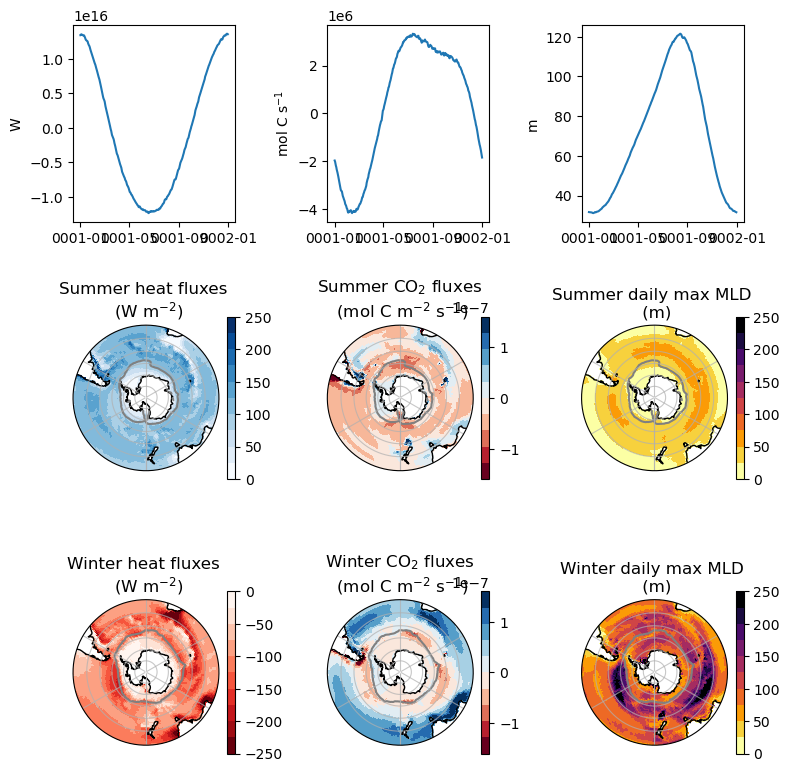

In [27]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3,3)

for i_v, v in enumerate(varnames):
    
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
    SO_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()

    ax_avg = fig.add_subplot(gs[0,i_v])
    if i_v == 2:
        SO_avg = SO_total / SO_area
        SO_avg.plot(ax=ax_avg)
    else:
        SO_total.plot(ax=ax_avg)
#    ax_avg.set_xticks(xt, xt_labels)
    ax_avg.set_xlabel('')
    ax_avg.set_ylabel(units[i_v])
    
    for i in np.arange(2):
        ibox = (i)*3+i_v
    
        ax_map = fig.add_subplot(gs[i+1,i_v], projection=ccrs.SouthPolarStereo())
    
        f = seasonal_means[i,:,:].plot(ax=ax_map, transform=ccrs.PlateCarree(), 
                                    add_colorbar=False,
                                       vmin=lim0[ibox], 
                                       vmax=lim1[ibox],
                                       cmap=cmaps[ibox])        
        if i==0:
            ds_ice.EXT.groupby(ds_ice.time.dt.season).mean(dim="time").sel(season="DJF").plot.contour(ax=ax_map, levels=[0.2],
                                                                                              colors="grey",transform=ccrs.PlateCarree())
        if i==1:
            ds_ice.EXT.groupby(ds_ice.time.dt.season).mean(dim="time").sel(season="JJA").plot.contour(ax=ax_map, levels=[0.2],
                                                                                              colors="grey",transform=ccrs.PlateCarree())            
        ax_map.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
        ax_map.gridlines(alpha=0.7)
        ax_map.set_boundary(circle, transform=ax_map.transAxes)
        ax_map.coastlines()
        ax_map.set_title(f"{seas[i]} {varnames_long[i_v]}")
        plt.colorbar(f, ax=ax_map, aspect=20, fraction = .05)
plt.tight_layout()
plt.savefig('CM4_seasonal_climatology.png', format="png", dpi=100, bbox_inches="tight")

In [ ]:
# adding fronts from Becki's data
path_orsi = '/home/Rebecca.Beadling/BAMS_SOTC2021_SO/SST_Mixed_Layer_Analysis/data/orsi_fronts'

In [ ]:
path_ocean_annual = "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_annual/ts/annual/5yr"

In [ ]:
ds_t = xr.open_mfdataset(f"{path_ocean_annual}/*thetao.nc", use_cftime=True)
ds_s = xr.open_mfdataset(f"{path_ocean_annual}/*.so.nc", use_cftime=True)
ds_z = xr.open_mfdataset(f"{path_ocean_annual}/*.zos.nc", use_cftime=True)

In [ ]:
t_avg = ds_t.thetao.sel(zl=0, method="nearest").mean(dim="time")

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
t_avg.differentiate("yh").plot(transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap=plt.get_cmap("RdBu"))
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
ds_z.zos.mean(dim="time").plot(transform=ccrs.PlateCarree(), cmap=plt.get_cmap("Reds", 10))
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
ds_t.thetao.sel(zl=100, method="nearest").mean(dim="time").plot(transform=ccrs.PlateCarree(), vmin=0, vmax=10, cmap=plt.get_cmap("Reds", 10))
ds_t.thetao.sel(zl=100, method="nearest").mean(dim="time").plot.contour(levels=[6.75],colors="black",transform=ccrs.PlateCarree())
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 8),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
ds_s.so.sel(zl=100, method="nearest").mean(dim="time").plot(transform=ccrs.PlateCarree(), vmin=34, vmax=35.5)
ds_s.so.sel(zl=100, method="nearest").mean(dim="time").plot.contour(levels=[34.8],colors="black",transform=ccrs.PlateCarree())
axs.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
axs.gridlines(alpha=0.7)
axs.set_boundary(circle, transform=axs.transAxes)
axs.coastlines()